# Fraud Detection Case Study Submission

## Business Context

This case requires trainees to develop a model for predicting fraudulent transactions for a financial company and use insights from the model to develop an actionable plan.

- Dataset: 6,362,620 rows, 10 columns (CSV)
- Goal: Fraudulent transaction detection
- Tools: Machine Learning (XGBoost, etc.)

---

## Candidate Expectations

You are required to answer the following questions:

1. Data cleaning including missing values, outliers and multi-collinearity.
2. Describe your fraud detection model in elaboration.
3. How did you select variables to be included in the model?
4. Demonstrate the performance of the model by using best set of tools.
5. What are the key factors that predict fraudulent customer?
6. Do these factors make sense? If yes, How? If not, How not?
7. What kind of prevention should be adopted while company update its infrastructure?
8. Assuming these actions have been implemented, how would you determine if they work?


In [9]:
# --- Setup
CSV_PATH = r"C:\Users\Amar Nath\Downloads\Accredian\Fraud.csv"
ARTIFACT_DIR = r"C:\Users\Amar Nath\Downloads\Accredian\artifacts_xgb"

import os
os.makedirs(ARTIFACT_DIR, exist_ok=True)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

DTYPES = {
    "step": "int16",
    "type": "category",
    "amount": "float32",
    "nameOrig": "string",
    "oldbalanceOrg": "float32",
    "newbalanceOrig": "float32",
    "nameDest": "string",
    "oldbalanceDest": "float32",
    "newbalanceDest": "float32",
    "isFraud": "int8",
    "isFlaggedFraud": "int8",
}
READ_KW = dict(dtype=DTYPES, low_memory=True)

# adjust NROWS=None for full dataset
NROWS = None
df = pd.read_csv(CSV_PATH, nrows=NROWS, **READ_KW)
df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.125,C786484425,339682.125,0.0,C776919290,0.000000e+00,339682.125,1,0
6362616,743,TRANSFER,6311409.500,C1529008245,6311409.500,0.0,C1881841831,0.000000e+00,0.000,1,0
6362617,743,CASH_OUT,6311409.500,C1162922333,6311409.500,0.0,C1365125890,6.848884e+04,6379898.000,1,0
6362618,743,TRANSFER,850002.500,C1685995037,850002.500,0.0,C2080388513,0.000000e+00,0.000,1,0
6362619,743,CASH_OUT,850002.500,C1280323807,850002.500,0.0,C873221189,6.510099e+06,7360101.500,1,0


In [11]:
# --- Feature Engineering
def engineer_features(df):
    df = df.copy()
    df["orig_delta"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
    df["dest_delta"] = df["newbalanceDest"] - df["oldbalanceDest"]
    df["orig_mismatch"] = (np.abs(df["orig_delta"] - df["amount"]) > 1e-3).astype("int8")
    df["dest_mismatch"] = (np.abs(df["dest_delta"] - df["amount"]) > 1e-3).astype("int8")
    df["dest_is_merchant"] = df["nameDest"].str.startswith("M").astype("int8")
    df["hour"] = (df["step"] % 24).astype("int8")
    df = df.drop(columns=["nameOrig","nameDest"])
    return df

df = engineer_features(df)
y = df["isFraud"]
X = df.drop(columns=["isFraud"])
print(X.shape, y.mean())


(6362620, 14) 0.001290820448180152


ROC-AUC=0.9997, PR-AUC=0.9938


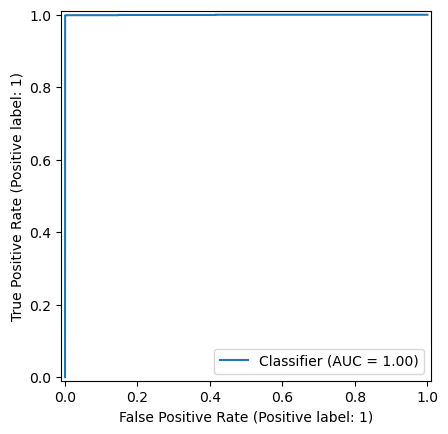

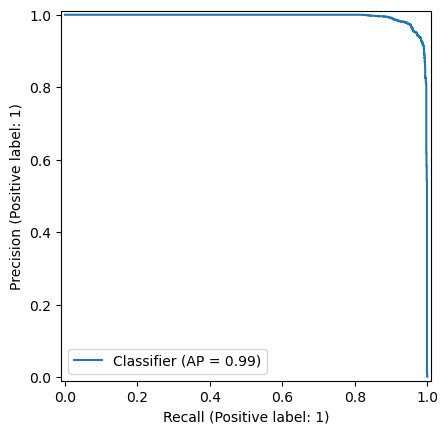

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.92      0.99      0.95      1643

    accuracy                           1.00   1272524
   macro avg       0.96      0.99      0.98   1272524
weighted avg       1.00      1.00      1.00   1272524

[[1270743     138]
 [     21    1622]]


In [13]:
# --- Train/Valid Split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

cat_cols = [c for c in X.columns if str(X[c].dtype)=="category"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ("num", "passthrough", num_cols),
])

xgb = Pipeline([("prep", preprocess),
                ("clf", XGBClassifier(
                    n_estimators=300,
                    max_depth=8,
                    learning_rate=0.1,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1]),
                    eval_metric="logloss",
                    n_jobs=-1,
                    random_state=42
                ))])

# --- Evaluation
def evaluate_model(model):
    model.fit(X_train, y_train)
    p_va = model.predict_proba(X_valid)[:,1]
    roc = roc_auc_score(y_valid, p_va)
    pr = average_precision_score(y_valid, p_va)
    print(f"ROC-AUC={roc:.4f}, PR-AUC={pr:.4f}")
    RocCurveDisplay.from_predictions(y_valid, p_va)
    plt.show()
    PrecisionRecallDisplay.from_predictions(y_valid, p_va)
    plt.show()
    y_hat = (p_va>=0.5).astype(int)
    print(classification_report(y_valid,y_hat))
    print(confusion_matrix(y_valid,y_hat))
    return model

fitted = evaluate_model(xgb)
